In [1]:
!pip install GPy

     |████████████████████████████████| 1.0MB 3.4MB/s 
     |████████████████████████████████| 71kB 7.7MB/s 
  Created wheel for GPy: filename=GPy-1.9.9-cp36-cp36m-linux_x86_64.whl size=2633981 sha256=00ad7e95312e4f7b474fc871cf4df42ccca719241ec578c80387a9d51aef973d
  Stored in directory: /root/.cache/pip/wheels/5d/36/66/2b58860c84c9f2b51615da66bfd6feeddbc4e04d887ff96dfa
  Created wheel for paramz: filename=paramz-0.9.5-cp36-none-any.whl size=102551 sha256=6baf1209ab5e1dd4971b108a47bd4978de665fab3b8dd14019a92e923bb9b4b3
  Stored in directory: /root/.cache/pip/wheels/c8/4a/0e/6e0dc85541825f991c431619e25b870d4b812c911214690cf8
Successfully built GPy paramz


In [0]:
import GPy
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import multivariate_normal


In [0]:
#tanh is applied but not used yet run_model function need to be edited, there would be blocks (refer variable - col_per) for predictions 
def getw(x, y):
  X_pseudo_inverse = np.dot(np.linalg.inv(np.dot(x.T,x)), x.T)
  w_in = np.dot(X_pseudo_inverse, y)
  return w_in

def make_basis_periodic_tanh(x,y):
    periodic = np.hstack([np.cos(2*np.pi*x),np.sin(2*np.pi*x),np.cos(4*np.pi*x),np.sin(4*np.pi*x),np.cos(6*np.pi*x),np.sin(6*np.pi*x),np.cos(8*np.pi*x),np.sin(8*np.pi*x),np.cos(10*np.pi*x),np.sin(10*np.pi*x),np.cos(12*np.pi*x),np.sin(12*np.pi*x)])
    w0 = np.ones((x.shape[0],1))
    tanh_calculated = np.tanh(w0 + x*getw(x,y))
    return np.hstack([np.ones((x.shape[0],1)),periodic, tanh_calculated]) 

def make_basis_tanh(x,y):
    
    w0 = np.ones((x.shape[0],1))
    tanh_calculated = np.tanh(w0 + x*getw(x,y))
    return np.hstack([np.ones((x.shape[0],1)), tanh_calculated]) 

def make_basis_linear_tanh(x,y):
    
    w0 = np.ones((x.shape[0],1))
    tanh_calculated = np.tanh(w0 + x*getw(x,y))
    return np.hstack([np.ones((x.shape[0],1)),x, tanh_calculated]) 
  
def make_basis_linear_periodic_tanh(x,y):
    # the components are 1,x, cos(2 \pi x), sin(2 \pi x)...
    periodic = np.hstack([np.cos(2*np.pi*x),np.sin(2*np.pi*x),np.cos(4*np.pi*x),np.sin(4*np.pi*x),np.cos(6*np.pi*x),np.sin(6*np.pi*x),np.cos(8*np.pi*x),np.sin(8*np.pi*x),np.cos(10*np.pi*x),np.sin(10*np.pi*x),np.cos(12*np.pi*x),np.sin(12*np.pi*x)])
    w0 = np.ones((x.shape[0],1))
    tanh_calculated = np.tanh(w0 + x*getw(x,y))
    return np.hstack([np.ones((x.shape[0],1)),x, periodic, tanh_calculated]) 
  
def test(x,y,plot=False):   
  H = make_basis_tanh(x.reshape(-1,1), y)
  return H



In [0]:
#Original basis functions
def make_basis(x):
    # the components are 1,x, cos(2 \pi x), sin(2 \pi x)...
    periodic = np.hstack([np.cos(2*np.pi*x),np.sin(2*np.pi*x),np.cos(4*np.pi*x),np.sin(4*np.pi*x),np.cos(6*np.pi*x),np.sin(6*np.pi*x),np.cos(8*np.pi*x),np.sin(8*np.pi*x),np.cos(10*np.pi*x),np.sin(10*np.pi*x),np.cos(12*np.pi*x),np.sin(12*np.pi*x)])
    return np.hstack([np.ones((x.shape[0],1)),x, periodic ]) 


In [0]:

#  periodic basis starts at column, this will only work if we use linear+periodic combination, if we go for non linear (yanh) there will be more blocks:

col_per = 2

#baseline model - right now its working on original basis function only
def run_model(x,y,functype, plot=False): 
    
    if (functype ==0):
      H = make_basis(x.reshape(-1,1))
    elif (functype ==1):
      H = make_basis_linear_periodic_tanh(x.reshape(-1,1),y)
    elif (functype ==2):
      H = make_basis_linear_tanh(x.reshape(-1,1),y)
    elif (functype ==3):
      H = make_basis_tanh(x.reshape(-1,1),y)
    elif (functype ==4):
      H = make_basis_periodic_tanh(x.reshape(-1,1),y)
      
    #normalize the data
    yn = (y-np.mean(y))/np.std(y)
    
    #select non periodic components of the basis
    #with non linear basis functions and various combinations this will have to be looked at or there would be more H variables
    H_np = H[:,0:col_per]

    with pm.Model() as model:
        #prior
        w = pm.Normal('weights', mu=0, sd=50, shape=(H.shape[1],))
        sigma = pm.HalfCauchy('sigma', 5)

        #linear model
        mu = pm.Deterministic('mu', pm.math.matrix_dot(H,w).T)

        #likelihood
        y_obs = pm.Normal('y', mu=mu, sd=sigma, observed=yn)

        #we can do  an approximated inference
    with model:
        inference = pm.ADVI()
        approx = pm.fit(60000, method=inference)
        
    posterior = approx.sample(draws=500)
    
    #could the strength of these be deciding factor which one to go for?
    #note the peridic basis also works with non linear, so its misleading
    
    print(np.mean(posterior['weights'],axis=0))
    
    all_prediction = np.dot(H,posterior['weights'].T).T
    
    non_periodic_prediction = np.dot(H_np,posterior['weights'][:,0:col_per].T).T
    if plot==True:
        plt.figure()
        plt.plot(x,np.mean(all_prediction,axis=0),'r', label='Overall Mean')
        plt.plot(x,np.mean(non_periodic_prediction,axis=0),'b', label='Mean of the non-periodic comp.')
        plt.legend()
        plt.scatter(x,yn)
        
    #Find no of intersections beween periodic and linear, for base code the lines cross 4 times, this would change with the competition data, the limit will have to be decided    
    idx = np.argwhere(np.diff(np.sign(np.mean(all_prediction,axis=0) - np.mean(non_periodic_prediction,axis=0)))).flatten()
    Gradients = []
    
    #4 is no of intersections, with training data these would be more 
    #If peridic, use non periodic for prediction, if there is no periodic, we have to use all for the prediction
    if(idx.shape[0]<4):
      for i in range(all_prediction.shape[0]):
          Gradients.append(np.min(np.gradient(all_prediction[i,:], x)))
    else:
      for i in range(non_periodic_prediction.shape[0]):
          Gradients.append(np.min(np.gradient(non_periodic_prediction[i,:], x)))

    posterior_probability_deriviative_is_positive = len(np.where(np.array(Gradients)>0)[0])/len(Gradients)
    print("probability that the function is increasing=", posterior_probability_deriviative_is_positive)
    if posterior_probability_deriviative_is_positive>0.95:
        return 1
    else:
        return 0



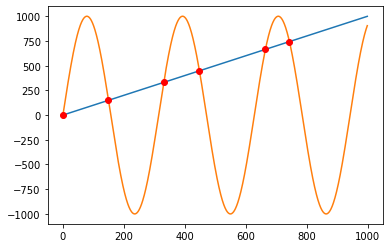

6

In [15]:

x = np.arange(0, 1000)
f = np.arange(0, 1000)
g = np.sin(np.arange(0, 10, 0.01) * 2) * 1000

plt.plot(x, f, '-')
plt.plot(x, g, '-')

idx = np.argwhere(np.diff(np.sign(f - g))).flatten()
plt.plot(f[idx], f[idx], 'ro')
plt.show()
idx.shape[0]

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Average Loss = 99.875: 100%|██████████| 60000/60000 [00:52<00:00, 1150.57it/s]
Finished [100%]: Average Loss = 99.874


[-0.67235493  1.30948084  0.03576319 -0.02734225  1.24484584 -0.01132356
  0.01797749  0.0358793   0.00180768 -0.0159065  -0.03877134  0.05048729
 -0.01914886 -0.02207002]
probability that the function is increasing= 1.0


1

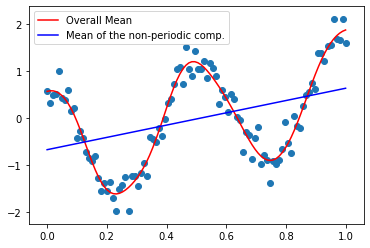

In [16]:
X = np.linspace(0,1,100)
Y =  X + np.cos(4*np.pi*X) + np.random.randn(len(X))*0.2

run_model(X,Y, 0, plot=True)

Average Loss = 130.01: 100%|██████████| 60000/60000 [00:54<00:00, 1103.69it/s]
Finished [100%]: Average Loss = 130


[-1.08318391  2.14406522  0.85008677 -0.11698972  0.24953364 -0.02221205
  0.13671641  0.00439519  0.07392695  0.03368748  0.02055806  0.06618088
  0.04489684  0.06857102]
probability that the function is increasing= 0.0


0

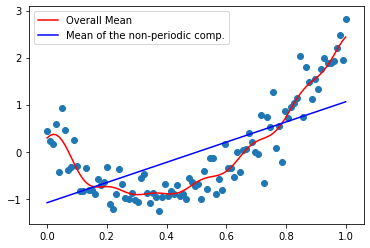

In [17]:
X = np.linspace(0,1,100)
Y =  X/2-2*np.exp(-(X-0.5)**2) + 2 + np.random.randn(len(X))*0.075

run_model(X,Y, 0, plot=True)

In [0]:
data = pd.read_csv('https://gitlab.com/vsambhe1/machine-learning-competition/raw/master/test.csv')

In [0]:
X = np.linspace(0,1,100)

Y = data.iloc[0,1:101].values
#the run model function is not ready for using non linear component that is tanh yet, that function needs modification
run_model(X,Y,1,plot=True)    

In [0]:
run_model(X,Y,2,plot=True)   

In [0]:
run_model(X,Y,3,plot=True)   

In [0]:
#review
Decision = pd.DataFrame(columns=['Id','Category'])

for r in range(10):
    id_row = data.iloc[r,0]
    Y = data.iloc[r,1:101].values
    decn = run_model(X,Y,0,plot=True)
    Decision = Decision.append({'Id': int(id_row), 'Category': int(decn)}, ignore_index=True)
    